In [39]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
import staple
from sklearn.metrics import jaccard_score
from tqdm import tqdm

import sys
sys.path.append('../')
from torchlib import post_processing_func
from torchlib.metrics import PQ
from torchlib.metrics import get_metrics

pq_score  = PQ()
map_post  = post_processing_func.MAP_post()
th_post   = post_processing_func.TH_post()
wts_post  = post_processing_func.WTS_post()

Path("summary").mkdir(parents=True, exist_ok=True)

In [40]:
def show(src, titles=[], suptitle="", 
         bwidth=4, bheight=4, save_file=False,
         show_axis=True, show_cbar=False):

    num_cols = len(src)
    
    plt.figure(figsize=(bwidth * num_cols, bheight))
    plt.suptitle(suptitle)

    for idx in range(num_cols):
        plt.subplot(1, num_cols, idx+1)
        if not show_axis: plt.axis("off")
        if idx < len(titles): plt.title(titles[idx])
        plt.imshow(src[idx]*1)
        if type(show_cbar) is bool:
            if show_cbar: plt.colorbar()
        elif idx < len(show_cbar) and show_cbar[idx]:
            plt.colorbar()
        
    plt.tight_layout()
    if save_file:
        plt.savefig(save_file)
        
def show2(src, titles=[], suptitle="", show_fig=True,
         bwidth=4, bheight=4, save_file=False,
         show_axis=True, show_cbar=False):

    num_cols = len(src)
    
    fig = plt.figure(figsize=(bwidth * num_cols, bheight*2))
    plt.suptitle(suptitle)

    add = 0
    for idx in range(num_cols):
        if idx == 6:
            add = 2
            
        plt.subplot(2, int(np.ceil(num_cols//2)+1), idx+1+add)
        if not show_axis: plt.axis("off")
        if idx < len(titles): plt.title(titles[idx])
        plt.imshow(src[idx]*1)
        if type(show_cbar) is bool:
            if show_cbar: plt.colorbar()
        elif idx < len(show_cbar) and show_cbar[idx]:
            plt.colorbar()
        
    plt.tight_layout()
    if save_file:
        Path(save_file).parent.mkdir(exist_ok=True, parents=True)
        plt.savefig(save_file)
        
    if not show_fig:
        plt.close(fig)
        
def get_stats_df(labs):
    full_stats = np.array([cv2.connectedComponentsWithStats(255-lab, connectivity=4) for lab in labs], dtype=object)

    full_n_cells = full_stats[:, 0].sum() - len(full_stats[:, 0])

    filter_stats = []
    for stat in full_stats[:, 2]:
        filter_stats.append(stat[1:])

    concat_stats = np.concatenate(filter_stats)

    df = pd.DataFrame(concat_stats, columns=['left', 'top', 'width', 'height', 'area'])
    df['Area G.M.'] = (df['width'] * df['height'])**(1/2)
    return df[['width', 'height', 'Area G.M.']]

def plot_norm_hist(imgs, labs):
    imgs = np.array(imgs)
    labs = np.array(labs)
    just0 = imgs[labs==0]
    just1 = imgs[labs==255]
    w0 = np.ones_like(just0)/just0.size
    w1 = np.ones_like(just1)/just1.size

    plt.hist(just0, bins=64, range=(0, 255), weights=w0, label="Class 0");
    plt.hist(just1, bins=64, range=(0, 255), weights=w1, label="Class 1");
    plt.legend()
    
def crop_images(imgs, labs):
    imgs = np.array(imgs)
    labs = np.array(labs)
    ishape = imgs.shape
    lshape = labs.shape
    
    hdif = (ishape[1] - lshape[1])//2
    wdif = (ishape[2] - lshape[2])//2
    
    if hdif <= 0 or wdif <= 0:
        return imgs
    return imgs[:, hdif:-hdif, wdif:-wdif]
    
def to3(src):
    shape = src.shape
    return np.stack((np.zeros_like(src), src.max()-src, src), axis=2)

def dice_score(gt, seg):
    jac = jaccard_score(gt.ravel(), seg.ravel())
    dice = (2*jac)/ (1+jac)
    return dice

def get_simple(segs, n_iter=10, alfa=0.2, verbose=False):
    new_segs = np.array(segs).copy()
    results, n_segs = [], []

    MV = (new_segs.sum(0)>= new_segs.shape[0]//2)
    new_weights = np.ones(len(new_segs))
    mdices, titles = [], []
    
    for epoch in range(n_iter):
        simple = (new_segs.transpose(1,2,0) * new_weights).sum(2) >= (new_weights.sum()/2)
        results.append(simple)
        n_segs.append(len(new_segs))
        dices = []
        for seg in new_segs:
            dice = dice_score(simple.ravel(), seg.ravel())
            dices.append(dice)
        
        dices  = np.array(dices)
        wdice = dices.sum()
        mdice = dices.mean()
        sdice = dices.std()
        mdices.append(mdice)
        
        t           = mdice - (alfa * sdice)
        new_segs    = new_segs[dices > t]
        new_weights = dices[dices > t]
        if len(new_segs)<=1:
            break
    if verbose: print(mdices, n_segs)
    return simple.astype(np.uint8)


In [297]:
#segs_list = [url.replace("labels2c", "") for url in  sorted(glob("/home/chcp/Datasets/[!_]*/[st][e]*/labels2c"))]

segs_list = [url.replace("labels2c", "") for url in  sorted(glob("/home/chcp/Datasets/[!_]*/[st][e]*/labels2c"))]
segs_list

['/home/chcp/Datasets/Seg1009_0.3.2/test/',
 '/home/chcp/Datasets/Seg1009_0.4.1/test/',
 '/home/chcp/Datasets/Seg33_1.0.1/test/',
 '/home/chcp/Datasets/Seg33_1.0.2/test/',
 '/home/chcp/Datasets/Seg33_1.0.3/test/',
 '/home/chcp/Datasets/Seg33_1.0.4/test/',
 '/home/chcp/Datasets/segprob1167_0.0.0/set/',
 '/home/chcp/Datasets/segprob19_0.0.0/set/',
 '/home/chcp/Datasets/segprob21_0.0.0/set/']

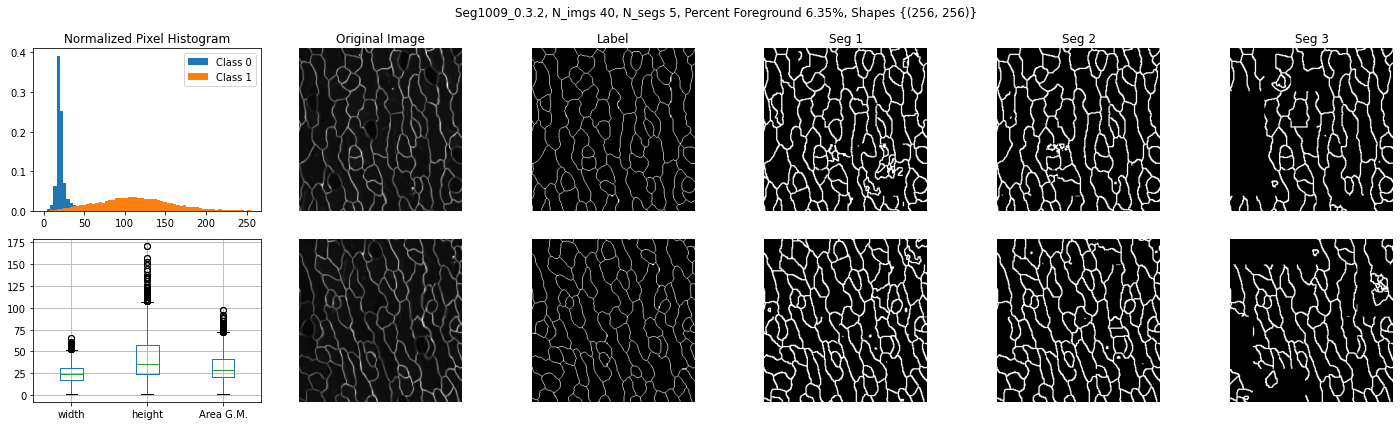

In [298]:
cols_per_data = 6
rows_per_data = 2

for url in segs_list:
    data_name = Path(url).parent.name
    
    img_path = url + '/images'
    lab_path = url + '/labels2c'
    out_path = url + '/outputs'
    idx_list = sorted([Path(url).stem for url in glob(lab_path+'/*')])
    num_img  = len(idx_list)
    num_segs = len(glob(out_path+'/*'))
    
    imgs = [cv2.imread(glob(img_path + f'/{idx}.*')[0], 0) for idx in idx_list]
    
    labs = [cv2.imread(glob(lab_path + f'/{idx}.*')[0], 0)*255 for idx in idx_list]
    
    imgs_shape = set([img.shape for img in imgs])
    id0 = int(num_img * (2/5))
    id1 = int(num_img * (3/5))
    percent1 = (np.array(labs).mean()/255)*100
    title = f"{data_name}, N_imgs {num_img}, N_segs {num_segs}, Percent Foreground {percent1:0.2f}%, Shapes {imgs_shape}"
    imgs = np.array(imgs)
    labs = np.array(labs)
    
    imgs = crop_images(imgs, labs)
    
    plt.figure(figsize=(20, 6))
    plt.suptitle(title)
    plt.subplot(rows_per_data, cols_per_data, 1);plt.title("Normalized Pixel Histogram")
    plot_norm_hist(imgs, labs)
    plt.subplot(rows_per_data, cols_per_data, 1 + cols_per_data)
    get_stats_df(labs).boxplot()
    
    plt.subplot(rows_per_data, cols_per_data, 2)
    plt.imshow(imgs[id0], cmap='gray');plt.axis('off');plt.title("Original Image")
    plt.subplot(rows_per_data, cols_per_data, 2 + cols_per_data)
    plt.imshow(imgs[id1], cmap='gray');plt.axis('off')
    
    plt.subplot(rows_per_data, cols_per_data, 3)
    plt.imshow(labs[id0], cmap='gray');plt.axis('off');plt.title("Label")
    plt.subplot(rows_per_data, cols_per_data, 3 + cols_per_data)
    plt.imshow(labs[id1], cmap='gray');plt.axis('off')
    
    outs_path = np.array(sorted(glob(out_path+f'/*/{idx_list[id0]}.*')))
    outs_path[[0, len(outs_path)//2, -1]]
    outputs = [cv2.imread(out_url,0)*255 for out_url in outs_path[[0, len(outs_path)//2, -1]]]
    
    plt.subplot(rows_per_data, cols_per_data, 4)
    plt.imshow(outputs[0], cmap='gray');plt.axis('off');plt.title("Seg 1")
    plt.subplot(rows_per_data, cols_per_data, 5)
    plt.imshow(outputs[1], cmap='gray');plt.axis('off');plt.title("Seg 2")
    plt.subplot(rows_per_data, cols_per_data, 6)
    plt.imshow(outputs[2], cmap='gray');plt.axis('off');plt.title("Seg 3")
        
    outs_path = np.array(sorted(glob(out_path+f'/*/{idx_list[id1]}.*')))
    outs_path[[0, len(outs_path)//2, -1]]
    outputs = [cv2.imread(out_url,0)*255 for out_url in outs_path[[0, len(outs_path)//2, -1]]]
    
    plt.subplot(rows_per_data, cols_per_data, 4 + cols_per_data)
    plt.imshow(outputs[0], cmap='gray');plt.axis('off')
    plt.subplot(rows_per_data, cols_per_data, 5 + cols_per_data)
    plt.imshow(outputs[1], cmap='gray');plt.axis('off')
    plt.subplot(rows_per_data, cols_per_data, 6 + cols_per_data)
    plt.imshow(outputs[2], cmap='gray');plt.axis('off')
    plt.tight_layout()
    #plt.savefig(f"summary/{data_name}.jpg")
    break

In [299]:
def get_static_ensamble(outputs):
    max_value  = max(1, outputs.max())
    maj_vote   = to3(((outputs//max_value).sum(0) >= (len(outputs)//2))*max_value)
    
    try:
        staple_res = staple.STAPLE(list(outputs), max_num_iterations=100_000).run()
        staple_res = to3(((staple_res > 0.5)*255).astype(np.uint8))
    except:
        staple_res = np.zeros_like(maj_vote)
        
        
    
    simple_res  = get_simple(outputs//max_value)*255
    simple_res  = to3(simple_res)
    
    return maj_vote, staple_res, simple_res

def to_instance(src):
    return map_post(src)[0]


def show_num(puzzle, label='', force_zeros=False):
    plt.imshow(puzzle)
    #plt.axis('off')
    for (j,i),label in np.ndenumerate(puzzle):
        plt.text(i,j,f"{label:0.2f}",ha='center',va='center', fontsize=16)

def show_mean_std(pq_matrices, label='', force_zeros=False):
    pq_mean = pq_matrices.mean(0)
    pq_std  = pq_matrices.std(0)
    
    plt.imshow(pq_mean)
    #plt.axis('off')
    for (j,i), mean_curr in np.ndenumerate(pq_mean):
        std_curr = pq_std[j,i]
        color = 'white' if mean_curr <= 0.35 else 'black'
        plt.text(i,j,f"  {mean_curr:0.2f}±\n{std_curr:0.2f}",ha='center',va='center', fontsize=16, color=color)

        
def print_pq_matrix(pq_matrix, ticks_label, pre_title='', save_fig=False):
    out_len = len(pq_matrix)
    
    fig = plt.figure(figsize=(10, 10))
    show_num(pq_matrix)

    plt.title(f"{pre_title} Mean Matrix: PQ vs PQ")
    plt.yticks(ticks=range(out_len), labels=ticks_label)
    plt.xticks(ticks=range(out_len), labels=ticks_label)
    #fig.axes[0].secondary_xaxis(True).set_xticklabels(['']+ticks_label)

    plt.colorbar()
    plt.tight_layout()
    plt.savefig(f"summary/{pre_title}_PQ.jpg")
    
def print_pq_matrixes(pq_matrixs, ticks_label, pre_title='', save_fig=False):
    out_len = len(pq_matrix[0])
    
    fig = plt.figure(figsize=(16, 12))
    show_mean_std(pq_matrixs)

    plt.title(f"{pre_title} Mean Matrix: PQ vs PQ")
    plt.yticks(ticks=range(out_len), labels=ticks_label)
    plt.xticks(ticks=range(out_len), labels=ticks_label)
    #fig.axes[0].secondary_xaxis(True).set_xticklabels(['']+ticks_label)

    plt.colorbar()
    plt.tight_layout()
    plt.savefig(f"summary/{pre_title}_PQ.jpg")
    
    

100%|██████████| 586/586 [00:00<00:00, 11315.39it/s]


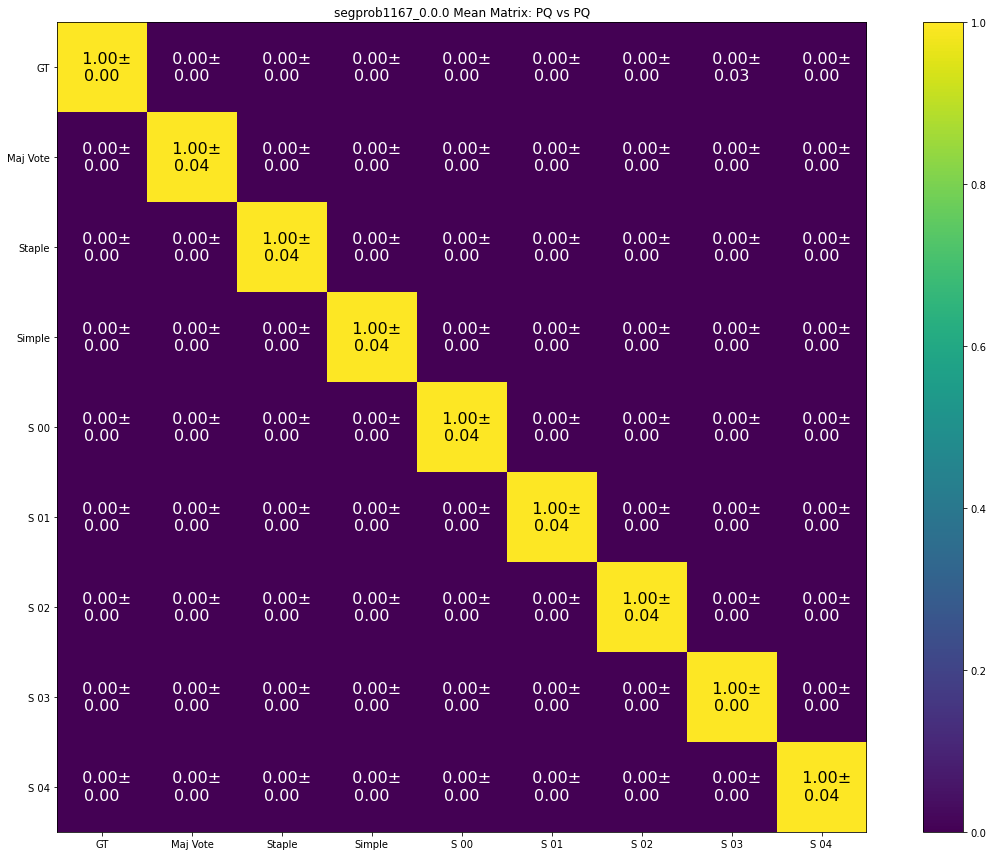

In [420]:
for url in segs_list[6:7]:
    data_name = Path(url).parent.name
    
    img_path = url + '/images'
    lab_path = url + '/labels2c'
    out_path = url + '/outputs'
    idx_list = sorted([Path(url).stem for url in glob(lab_path+'/*')])
    num_img  = len(idx_list)
    num_segs = len(glob(out_path+'/*'))
    
    if num_segs > 20 or num_img > 600:
        print(f"{data_name} Skip!: {num_segs}; {num_img}")
        continue
    
    imgs = [cv2.imread(glob(img_path + f'/{idx}.*')[0], 0) for idx in idx_list]
    labs = [cv2.imread(glob(lab_path + f'/{idx}.*')[0], 0)*255 for idx in idx_list]
    
    imgs_shape = set([img.shape for img in imgs])
    id0 = int(num_img * (2/5))
    id1 = int(num_img * (3/5))
    percent1 = (np.array(labs).mean()/255)*100
    title = f"{data_name}, N_imgs {num_img}, N_segs {num_segs}, Percent Foreground {percent1:0.2f}%, Shapes {imgs_shape}"
    imgs = np.array(imgs)
    labs = np.array(labs)
    
    imgs = crop_images(imgs, labs)
    
    data_len = len(idx_list)
    out_len  = num_segs + 4

    pq_matrix = np.zeros((data_len, out_len, out_len))
    for idx in range(data_len):
        np.fill_diagonal(pq_matrix[idx], 1)
    
    for idx_sample in tqdm(range(len(idx_list))):
        if idx_sample != 500: continue

        if (labs[idx_sample]/labs.max()).sum() <= labs.size * 0.00001:
            continue
        #outs_path  = np.array(sorted(glob(out_path+f'/*/{idx_list[idx_sample]}.*')))
        outs_path  = [url + f'/{idx_list[idx_sample]}.tif' for url in glob(out_path+'/*')]
        
        if len(outs_path) != num_segs:
            continue
            
        outputs    = np.array([cv2.imread(out_url,0) if Path(out_url).exists() 
                               else np.zeros_like(labs[idx_sample]) for out_url in outs_path])
        outputs    *= 255

        lab0 = to3(labs[idx_sample])
        lab0 = to_instance(lab0)
        
        maj_vote, staple_res, simple_res = get_static_ensamble(outputs)
        maj_votei, staple_resi = to_instance(maj_vote), to_instance(staple_res)
        simple_resi = to_instance(simple_res)
        outputsi = [lab0, maj_votei, staple_resi, simple_resi] + [map_post(to3(out))[0] for out in outputs]
        ticks_label = ["GT", "Maj Vote", "Staple", "Simple"] + [f"S {idl:02d}" for idl in range(len(outputs))]

        #show(outputsi, titles=ticks_label)
            
        for idx in range(out_len):
            for idy in range(idx, out_len):
                pq_xy = pq_score(outputsi[idx], outputsi[idy])['pq']
                pq_matrix[idx_sample, idx, idy] = pq_xy
                #pq_matrix[id_data, idy, idx] = pq_xy
                
    print_pq_matrixes(pq_matrix, ticks_label, data_name)

In [425]:
idz = 3
pq_score(outputsi[idz], outputsi[idz])['pq']

0